In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir

import scipy.cluster.hierarchy as sch
from scipy import stats

from keras.models import *
from keras.layers import *

Using TensorFlow backend.


In [2]:
### READ DATA ###

data, person_id = [], []
for txt in listdir('./Walk_MODEL'):
    measure = pd.read_csv('./Walk_MODEL/'+txt, sep=' ', header=None).values
    data.append(measure)
    person_id.append(txt.split('-')[-1].split('.')[0])

data = np.asarray(data)
data.shape

(20, 170, 3)

Text(0.5,1,'f3')

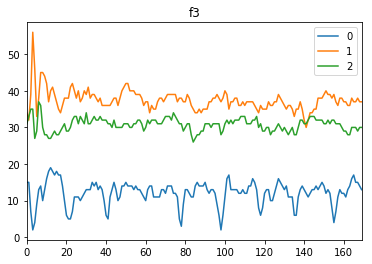

In [3]:
### EXEMPLE OF DATA FOR A SINGLE INDIVIDUAL ###

pd.DataFrame(data[10]).plot(legend=['X','Y','Z'])
plt.title(person_id[11])

In [4]:
### STANDARDIZE DATA ###

def std(serie): return (serie - serie.mean(axis=0))/serie.std(axis=0)
def reverse_std(serie): return serie.std(axis=0)+serie.mean(axis=0)

reverse_data = np.asarray([s.std(axis=0)+s.mean(axis=0) for s in data])
data = np.asarray([(s-s.mean(axis=0))/s.std(axis=0) for s in data])
data.shape

(20, 170, 3)

# DIMENSIONALITY REDUCTION

In [5]:
input_layer = Input(shape=(data.shape[1], 3))
encoder = TimeDistributed(Dense(200, activation='relu'))(input_layer)
encoder = TimeDistributed(Dense(50, activation="relu"))(encoder)

decoder = TimeDistributed(Dense(50, activation='relu'))(encoder)
decoder = TimeDistributed(Dense(200, activation='relu'))(decoder)

out = TimeDistributed(Dense(3))(decoder)

autoencoder = Model(inputs=input_layer, outputs=out)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 170, 3)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 170, 200)          800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 170, 50)           10050     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 170, 50)           2550      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 170, 200)          10200     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 170, 3)            603       
Total params: 24,203
Trainable params: 24,203
Non-trainable params: 0
_________________________________________________________________


In [7]:
autoencoder.fit(data[:10],data[:10], epochs=100, shuffle=True, verbose=2)

Epoch 1/100
 - 0s - loss: 0.9918
Epoch 2/100
 - 0s - loss: 0.9601
Epoch 3/100
 - 0s - loss: 0.9350
Epoch 4/100
 - 0s - loss: 0.9066
Epoch 5/100
 - 0s - loss: 0.8766
Epoch 6/100
 - 0s - loss: 0.8444
Epoch 7/100
 - 0s - loss: 0.8095
Epoch 8/100
 - 0s - loss: 0.7716
Epoch 9/100
 - 0s - loss: 0.7307
Epoch 10/100
 - 0s - loss: 0.6868
Epoch 11/100
 - 0s - loss: 0.6393
Epoch 12/100
 - 0s - loss: 0.5886
Epoch 13/100
 - 0s - loss: 0.5351
Epoch 14/100
 - 0s - loss: 0.4790
Epoch 15/100
 - 0s - loss: 0.4214
Epoch 16/100
 - 0s - loss: 0.3631
Epoch 17/100
 - 0s - loss: 0.3059
Epoch 18/100
 - 0s - loss: 0.2515
Epoch 19/100
 - 0s - loss: 0.2021
Epoch 20/100
 - 0s - loss: 0.1600
Epoch 21/100
 - 0s - loss: 0.1275
Epoch 22/100
 - 0s - loss: 0.1057
Epoch 23/100
 - 0s - loss: 0.0939
Epoch 24/100
 - 0s - loss: 0.0889
Epoch 25/100
 - 0s - loss: 0.0858
Epoch 26/100
 - 0s - loss: 0.0803
Epoch 27/100
 - 0s - loss: 0.0709
Epoch 28/100
 - 0s - loss: 0.0585
Epoch 29/100
 - 0s - loss: 0.0458
Epoch 30/100
 - 0s - lo

Text(0.5,1,'reconstruction error f3')

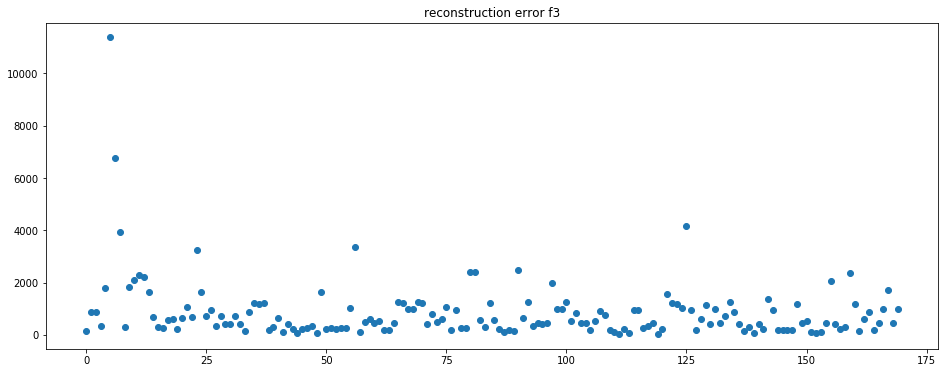

In [8]:
### TRY TO RECONSTRUCT ERRORS ###

predictions = autoencoder.predict(data[11][np.newaxis,:,:]) * reverse_data[11]

mse = np.mean(np.power(data[11] - predictions[0], 2), axis=1)

plt.figure(figsize=(16,6))
plt.scatter(y=mse,x=range(data.shape[1]))
plt.title('reconstruction error '+person_id[11])

In [9]:
def reconstructe_error(series, reverse_data):
    
    predictions = autoencoder.predict(series[np.newaxis,:,:]) * reverse_data
    mse = np.mean(np.power(series - predictions[0], 2), axis=1)
    return mse

# CORRELATION CLUSTERING

(170, 10)


([<matplotlib.axis.YTick at 0x29a8e84d048>,
 <a list of 10 Text yticklabel objects>)

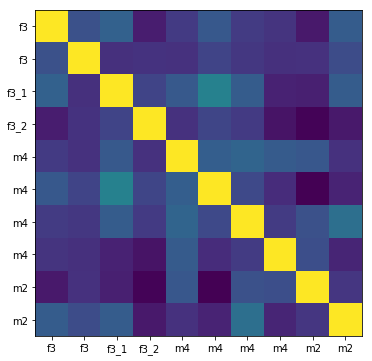

In [10]:
### COMPUTE CORRELATION MATRIX ###

df = pd.DataFrame([reconstructe_error(series,reverse) for series,reverse in zip(data[10:],reverse_data[10:])]).T
print(df.shape)

plt.figure(figsize=(6,6))
plt.imshow(df.corr())
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])

([<matplotlib.axis.YTick at 0x29a8e683d68>,
 <a list of 10 Text yticklabel objects>)

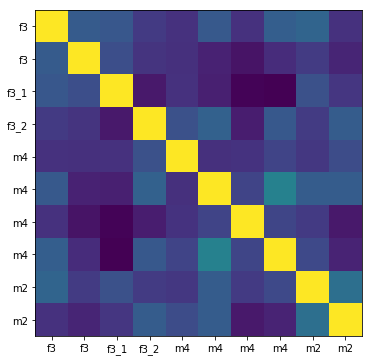

In [11]:
### HIERACHICAL CLUSTERING ###

X = df.corr().values
d = sch.distance.pdist(X)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max()*0.99, 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df = df.reindex(columns, axis=1)

plt.figure(figsize=(6,6))
plt.imshow(df.corr())
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])

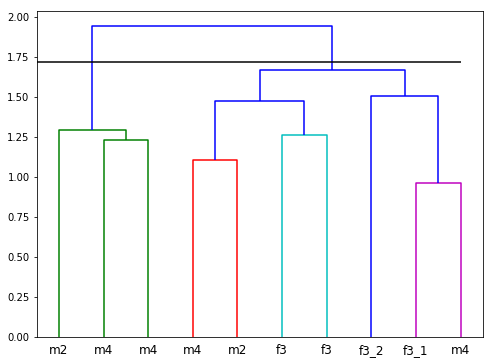

In [12]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.hlines(d.max()*0.99,0,np.max(dendrogram['icoord']))

# KOLMOGOROV SMIRNOV CLUSTERING

(170, 10)


([<matplotlib.axis.YTick at 0x29a8e7490f0>,
 <a list of 10 Text yticklabel objects>)

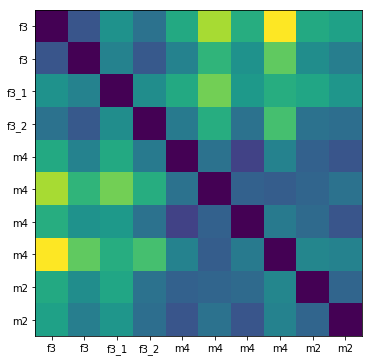

In [13]:
### COMPUTE KOLMOGOROV SMIRNOV MATRIX ###

df = pd.DataFrame([reconstructe_error(series,reverse) for series,reverse in zip(data[10:],reverse_data[10:])]).T
print(df.shape)

results = []
for i in range(len(df.columns)):
    kf_test = df.apply(lambda x: stats.ks_2samp(df.iloc[:,i].values, x)[0],axis=0)
    results.append(kf_test.tolist())

plt.figure(figsize=(6,6))
plt.imshow(results)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])

([<matplotlib.axis.YTick at 0x29a8e7c7518>,
 <a list of 10 Text yticklabel objects>)

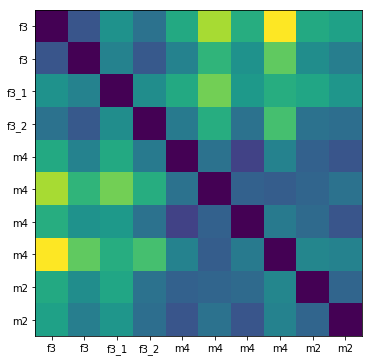

In [14]:
### HIERACHICAL CLUSTERING ###

X = np.asarray(results)
d = sch.distance.pdist(X)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max()*0.99, 'distance')

plt.figure(figsize=(6,6))
plt.imshow(X[:,np.argsort(ind)])
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])

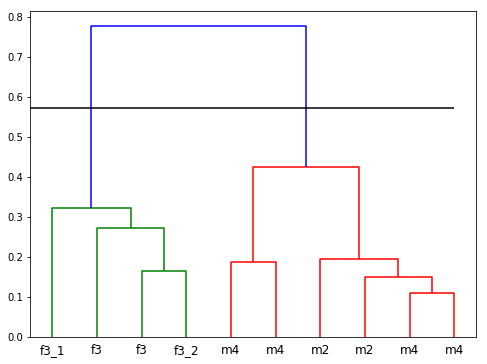

In [15]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.hlines(d.max()*0.95,0,np.max(dendrogram['icoord']))